### **Proyecto Final Optimización e Inteligencia Artificial 2024-02**

## Juan Botero

# Redes Neuronales

In [23]:
# Se instala el paquete para optimización de hiperparámetros
!pip install keras-tuner --upgrade

In [1]:
# Se importan las librerías requeridas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-03-04 08:32:40.080724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741095160.168423     816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741095160.193659     816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-04 08:32:40.387833: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cargar el dataset
fault_data = pd.read_csv('./all_faults_dataset.csv', index_col=0)

In [3]:
relays = pd.unique(fault_data['Relay'])
transform = dict(zip(relays, list(range(len(relays)))))
fault_data.replace(transform, inplace=True)

/tmp/ipykernel_816/875189200.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fault_data.replace(transform, inplace=True)


In [4]:
fault_data.head()

,Relay,inside,R,X,V,I
0,0,1,0.041659,0.489193,0.014439,5.857787
1,0,1,3.861041,0.711635,0.113567,5.761720
2,0,1,7.708948,0.930964,0.218630,5.608261
3,0,1,11.585692,1.147093,0.316192,5.409643
4,0,1,15.491589,1.359930,0.404407,5.179814


In [5]:
target = fault_data.loc[:, 'inside']
fault_data = fault_data.loc[:, fault_data.columns != 'inside']

In [6]:
alpha = 1-((target == 1).sum()/target.count())

In [7]:
# Dividir los datos en entrenamiento, prueba y validación con porcentajes de 60, 25 y 15% respectivamente
x_train, x_test, y_train, y_test = train_test_split(fault_data, target, test_size=0.25)
# El 20% del 75% es el 15% del total
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train, test_size=0.2)

In [8]:
print((y_train == 1).sum())
print((y_valid == 1).sum())
print((y_test == 1).sum())

4278
1026
1736


In [9]:
# Normalización de los datos
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
# Se entrena el normalizador únicamente con los datos de entrenamiento para independizar los conjuntos de validación y prueba
x_valid = scaler.transform(x_valid)
x_test = scaler.transform(x_test)

In [10]:
# Se crea la función para definición del modelo con optimización de hiperparámetros
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
def model_builder(hp):
    optimizer_type = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])

    if optimizer_type == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]))
    elif optimizer_type == 'sgd':
        optimizer = SGD(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]))
    else:
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', [0.0001, 0.001, 0.01]))
    model = keras.Sequential()
    # Capa de entrada con optimizacion del numero de neuronas
    model.add(keras.layers.Dense(hp.Int('units_0',min_value=20,max_value=80,step=10), activation="relu", input_shape=(5,)))
    # Optimizacion del numero de capas ocultas adicionales
    for i in range(hp.Int('num_layers', 1, 4)):
          model.add(keras.layers.Dense(units=hp.Int('units_' + str(i+1),min_value=20,max_value=80,step=10),
                                 activation='relu'))
    # Capa de salida
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    # Optimización de gamma
    hp_gamma = hp.Int('gamma',min_value=1,max_value=5,step=1)
    # Compilacion
    model.compile(optimizer=optimizer, loss=keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True, alpha=alpha ,gamma=hp_gamma),  
                  metrics=[keras.metrics.AUC(curve='PR')])
    return model

In [11]:
# Se aplica la búsqueda aleatoria
tuner = kt.RandomSearch(model_builder,
                        objective='val_auc',
                        max_trials=30,
                        overwrite=True)
tuner.search(x_train,y_train,epochs=100,
             validation_data=(x_valid,y_valid), callbacks=[early_stopping])

Trial 30 Complete [00h 09m 20s]
val_auc: 0.7830460071563721

Best val_auc So Far: 0.9907407760620117
Total elapsed time: 03h 26m 36s


In [12]:
# Se obtiene el mejor modelo entrenado
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

/home/andres/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 40)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,501 (25.39 KB)

 Trainable params: 6,501 (25.39 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Parametros seleccionados
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_auc", direction="max")

Trial 02 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.001
units_0: 60
num_layers: 2
units_1: 60
gamma: 4
units_2: 40
Score: 0.9907407760620117

Trial 04 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.001
units_0: 70
num_layers: 2
units_1: 60
gamma: 3
units_2: 60
Score: 0.9839872121810913

Trial 17 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0001
units_0: 40
num_layers: 4
units_1: 70
gamma: 5
units_2: 40
units_3: 40
units_4: 70
Score: 0.9837029576301575

Trial 25 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.0001
units_0: 60
num_layers: 3
units_1: 60
gamma: 4
units_2: 60
units_3: 40
units_4: 50
Score: 0.9812583327293396

Trial 00 summary
Hyperparameters:
optimizer: adam
learning_rate: 0.001
units_0: 30
num_layers: 2
units_1: 60
gamma: 2
units_2: 20
Score: 0.9768148064613342

Trial 24 summary
Hyperparameters:
optimizer: adam
le

In [14]:
# Se evalua el desempeño del modelo
best_model.evaluate(x_test, y_test)

935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc: 0.9873 - loss: 2.3412e-04


[0.0002134781825589016, 0.9904541969299316]

In [15]:
y_pred=np.round(best_model.predict(x_test))

935/935 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


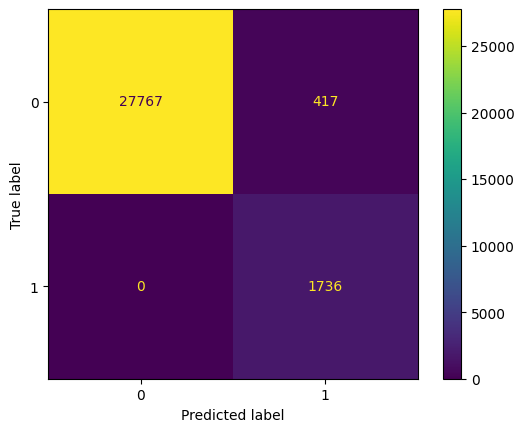

In [16]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pd.unique(y_test))
disp.plot()

In [41]:
best_model.save('fault_neural_network.keras')